**<h2> Nombres: </h2>**
    
 - <h3> Joan G. Bofill. </h3>
 - <h3> David A. Espinosa. </h3>

 ---

Este proyecto fue hecho en el marco del curso de Minería de Datos. Este y otros contenidos disponibles en el enlace: https://github.com/AprendizajeProfundo 

#**Proyecto:**

## **A**nálisis de **E**mociones por medio de **A**udios

###Curso: [Minería de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos)

Consiste en una aplicación de machine learning que clasificará audios de diferentes interlocutores (actores) respecto a las emociones asociadas a su discurso.

- Base de datos: https://drive.google.com/file/d/1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7/view
    - Etiquetas de los archivos:
      - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
      - Vocal channel (01 = speech, 02 = song).
      - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
      - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
      - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
      - Repetition (01 = 1st repetition, 02 = 2nd repetition).
      - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
      
    - (Para mayor información visitar: https://zenodo.org/record/1188976#.XoPj5M17ntE )

- Clasificación de audios:
    - https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    - https://towardsdatascience.com/sound-classification-using-images-68d4770df426

- Python audios: https://www.youtube.com/watch?v=vJ_WL9aYfNI


## Base de datos:

- Se monta el nuestra unidad dedrive para poder utilizar la base de datos guardada allí.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Se llaman las librerías a utilizar en esta primera fase.










In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from glob import glob #usa las reglas de shell de Unix para buscar nombres de archivos que coincidan con un patrón.
import librosa as lr #audios
import re #dividir cadena respecto a caracteres
from itertools import islice
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
from scipy.fftpack import fft
from scipy.signal import get_window

- Se crea un diccionario para decodificar el nombre de los archivos (obtener sus características).



In [ ]:
d = { 'modality': {'01': 'full av', '02': 'video only', '03': 'audio only'},
      'vocal channel': {'01': 'speech', '02': 'song'},
      'emotion': {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad','05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'},
      'emotional intensity': {'01': 'normal', '02': 'strong'},
      'statement': {'01': 'kids are talking by the door', '02': 'dogs are sitting by the door'},
      'repetition': {'01': '1st repetition', '02': '2nd repetition'},
      'actor': {'00': 'female', '01': 'male'}}

- Se crea otro diccionario con base al anterior invirtiendo los parámetros 'values' y 'keys' para buscar archivos (algo así como un traductor).

In [ ]:
dt = {} #iniciliazar diccionario

for k, v in d.items():
  dt[k] = dict([(value, key) for key, value in v.items()])

dt

{'actor': {'female': '00', 'male': '01'},
 'emotion': {'angry': '05',
  'calm': '02',
  'disgust': '07',
  'fearful': '06',
  'happy': '03',
  'neutral': '01',
  'sad': '04',
  'surprised': '08'},
 'emotional intensity': {'normal': '01', 'strong': '02'},
 'modality': {'audio only': '03', 'full av': '01', 'video only': '02'},
 'repetition': {'1st repetition': '01', '2nd repetition': '02'},
 'statement': {'dogs are sitting by the door': '02',
  'kids are talking by the door': '01'},
 'vocal channel': {'song': '02', 'speech': '01'}}

- Se define la dirección en donde se encuentran los datos (deben estar cargados en drive).

In [ ]:
data_p = '/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)' #path de los datos

- Se crea una función para la búsqueda de archivos (nombres codificados) en la base.


In [ ]:
def find_d(modality='??', vocal_channel='??', emotion='??', emotional_intensity='??', statement='??', repetition='??', actor_gender='??', actor_id='??'):

  if actor_id == '??': #buscar género
    if actor_gender != '??':
      if actor_gender == '00':
        actor_id = '?' + str(np.arange(0,9,2))
      elif actor_gender == '01':
        actor_id = '?' + str(np.arange(1,10,2))
      else:
        raise ValueError('Género no váĺido')

  audio_f = glob(data_p + '/Actor_{}/{}-{}-{}-{}-{}-{}-{}.wav'.format(actor_id, modality, vocal_channel, emotion, emotional_intensity, statement, repetition, actor_id))
  return(audio_f) #path de audios con dichas características

In [ ]:
find_d(actor_gender='01', emotion='04', repetition='02')[:5]

['/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_01/03-01-04-01-01-02-01.wav',
 '/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_01/03-01-04-01-02-02-01.wav',
 '/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_01/03-01-04-02-01-02-01.wav',
 '/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_01/03-01-04-02-02-02-01.wav',
 '/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_03/03-01-04-01-01-02-03.wav']

In [ ]:
len(find_d(actor_gender='01', emotion='04', repetition='02'))

48

 - **TO DO** Se crea una función para la búsqueda de archivos (nombres decodificados) en la base. 

In [ ]:
def find_dt(emotion=None):

  if emotion == None:
    emo = '??'
  elif emotion != None and emotion not in dt['emotion'].keys():
    raise ValueError("ERROR: Los valores deben ser {}.".format(d_t['emotion'].keys()))
  else:
    emo = dt['emotion'][emotion]

  return(find_d(emotion=emo))

In [ ]:
len(find_dt('sad'))

192

- Se carga un archivo de audio de los 192 anteriores.

In [ ]:
audio_f = find_dt('sad')[0]

audio, sfreq = lr.load(audio_f) #sfreq = cuántas unidades equivalen un segundo.
time = np.arange(0, len(audio)) / sfreq

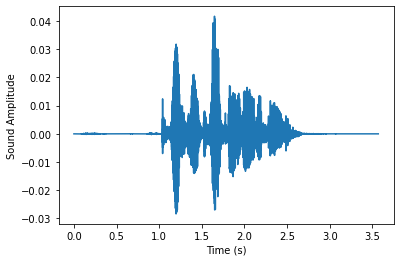

In [ ]:
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

- Se define una función para obtener la información del archivo.

In [ ]:
def dec(audio_p):
  cod = audio_p[-24:] #obtiene últimos carácteres de la cadena de la ubicación del archivo.
  print(cod, '\n')
  nm = re.split('-|\.', cod)[:-1] #separa estos carácteres.
  nm[-1] = '0' + str(int(nm[-1]) % 2) #muestra el género del actor

  h = 0 #contador
  for k, v in d.items(): #imprimir información del archivo
    print('{}: {}'.format(k, d[k][nm[h]]))
    h += 1

In [ ]:
dec(audio_f)

03-01-04-01-01-02-01.wav 

modality: audio only
vocal channel: speech
emotion: sad
emotional intensity: normal
statement: kids are talking by the door
repetition: 2nd repetition
actor: male


Vamos a intentar transformar el archivo de audio en una imagen que nos ofrezca más detalles para su posterios clasificación.

In [ ]:
clip, sample_rate = librosa.load(audio_f, sr=None)
print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   16000 Hz
Clip Length   3.57 seconds


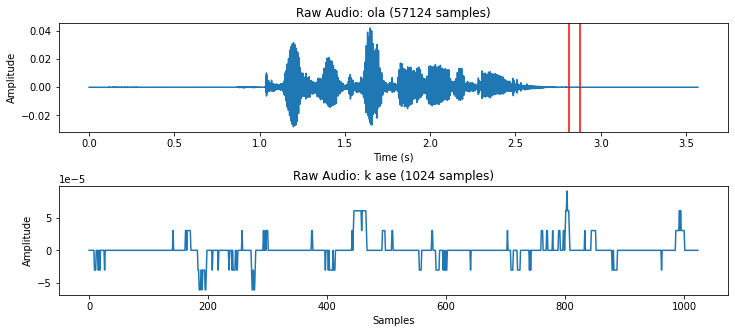

In [ ]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format("ola", len(clip)))


n_fft = 1024 # frame length 
start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format("k ase", len(x)));

A continuación, presentaremos el archivo de audio de ejemplo con el que estamos trabajando que corresponde al primero de los que tenían la emoción "tristeza".

In [ ]:
Audio(clip, rate=sample_rate)

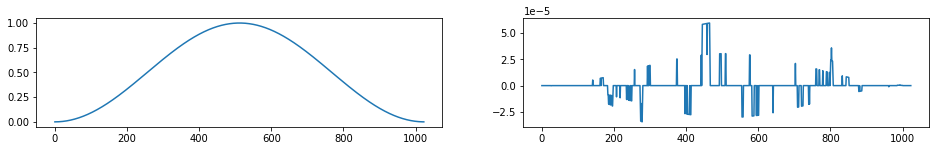

In [ ]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

In [ ]:
# Compute (real) FFT on window (Transformada Rápida de Fourier)
X = fft(x, n_fft)
X.shape, X.dtype

((1024,), dtype('complex64'))

((513,), dtype('float32'))

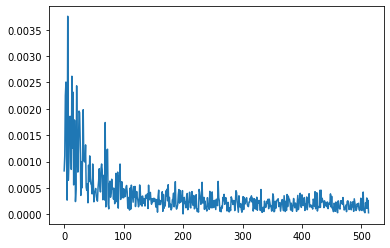

In [ ]:
# Solo se usan los primeros (n_fft/2)+1 números de la salida, ya que la segunda mitad es redundante.
X = X[:n_fft//2+1]

# Convierte de rectangular a polar, usualmente solo importa la magnitud
X_magnitude, X_phase = librosa.magphase(X)

plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

Ya que nosotros oímos en decibeles (que es una escala logarítmica de la amplitud), resulta interesante expresar el gráfico anterior en decibeles mediante la siguiente función.

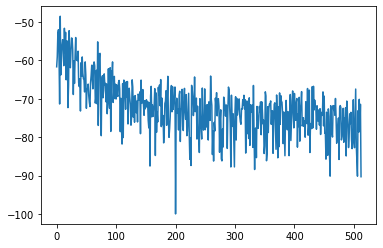

In [ ]:
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)

plt.plot(X_magnitude_db);


Para generar información sobre todo el archivo, podemos tomar una FFT de una ventana de 1024 muestras y deslizarla por 512 muestras (longitud de salto, hop-length) para que las ventanas se superpongan entre sí. Para este archivo de tres segundos, eso nos dará 259 espectros de frecuencia, que luego podemos ver como una imagen bidimensional. Esto se llama Transformada de Fourier a corto plazo (STFT) y nos permite ver cómo cambian las diferentes frecuencias con el tiempo.

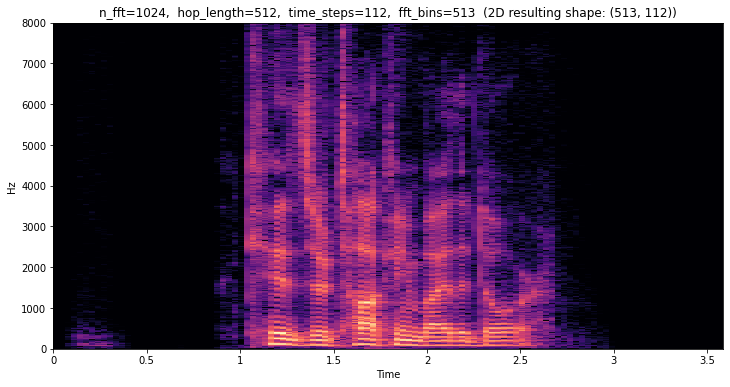

In [ ]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

La imagen anterior no muestra con precisión cómo los humanos perciben las frecuencias. Junto con el volumen, también escuchamos frecuencias en una escala logarítmica. Oiríamos la misma "distancia" de frecuencias de 50 Hz a 100 Hz que escucharíamos entre 400 Hz y 800 Hz. Estas son algunas de las razones por las cuales muchas personas usan melspectrograms que transforman los intervalos de frecuencia en la escala mel. Librosa nos permite convertir fácilmente un espectrograma regular en un electrograma milimétrico, y nos permite definir cuántos "bins" queremos tener. También podemos especificar una frecuencia mínima y máxima en la que queremos que nuestros contenedores se dividan en

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


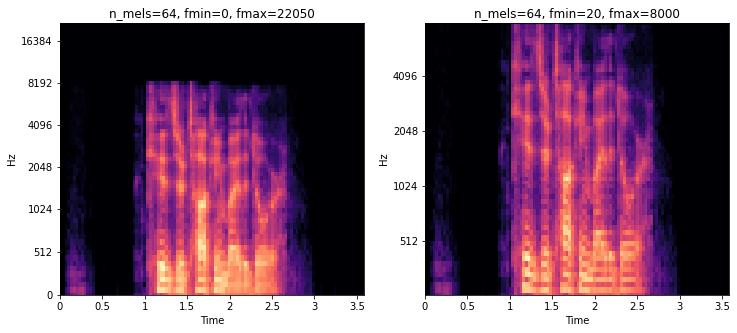

In [ ]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 22050 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()

## Exportar imágenes

Luego de crear una carpeta en el directorio del proyecto en nuestro drive para almacenar las imágenes correspondientes a los audios, se procede a declarar la dirección de esta.

In [ ]:
data_i = '/content/drive/My Drive/project(dm)/speech_img/' #path de los datos

In [ ]:
audio_path = find_dt()
len(audio_path)

1440

In [ ]:
audio_path[0]

'/content/drive/My Drive/project(dm)/speech-emotion-recognition-ravdess-data.zip (Unzipped Files)/Actor_01/03-01-01-01-01-01-01.wav'

In [ ]:
audio_path[0][-24:-4]

'03-01-01-01-01-01-01'

Con la siguiente instrucción, vamos a exportar todas las imágenes generadas por medio de la transformada de Fourier con la librería Librosa en la carpeta "speech_img" del directorio de nuestro proyecto. Solo es necesario correrla una vez. (Tarda unos 15-20 minutos). Cabe mencionar que se usan unos parámetros usuales que encontramos en trabajos similares de tratamiento de audio y que nos garantizan que el tamaño de todas las imágenes es el mismo.

In [ ]:
# number of mel frequency bands 
n_fft = 1024
hop_length = 512
n_mels = 64
fmin = 20
fmax = 8000
n_mels = 64

plt.ioff()

for i in range(len(audio_path)):

  audio_f = audio_path[i]
  nm = audio_f[-24:-4]

  clip, sample_rate = librosa.load(audio_f, sr=None)

  mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
  n_mels=n_mels, sr=sample_rate, power=1.0,
  fmin=fmin, fmax=fmax)

  mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

  fig = plt.figure(figsize=(10, 5))
  librosa.display.specshow(mel_spec_db,  
  sr=sample_rate, hop_length=hop_length, 
  fmin=fmin, fmax=fmax)

  plt.savefig(data_i + nm + '.png', bbox_inches='tight', pad_inches=-0.05)
  plt.close(fig)

In [ ]:
mel_spec_db

array([[-80.        , -80.        , -68.71778588, ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -67.50726794, ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -70.76366236, ..., -80.        ,
        -80.        , -80.        ],
       ...,
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]])

**BUSCAR** ARCHIVOS

Análogamente a lo que se hizo con los audios, se crean funciones para buscar las imágenes (que conservan los mismos nombres y por tanto la misma codificación). Por tanto, la longitod coincide con el tamaño de nuestra muestra.

In [ ]:
def find_di(modality='??', vocal_channel='??', emotion='??', emotional_intensity='??', statement='??', repetition='??', actor_gender='??', actor_id='??'):

  if actor_id == '??': #buscar género
    if actor_gender != '??':
      if actor_gender == '00':
        actor_id = '?' + str(np.arange(0,9,2))
      elif actor_gender == '01':
        actor_id = '?' + str(np.arange(1,10,2))
      else:
        raise ValueError('Género no váĺido')

  audio_f = glob(data_i + '{}-{}-{}-{}-{}-{}-{}.png'.format(modality, vocal_channel, emotion, emotional_intensity, statement, repetition, actor_id))
  return(audio_f) #path de imágenes con dichas características

In [ ]:
len(find_di())

1440

In [ ]:
def find_dti(emotion=None):

  if emotion == None:
    emo = '??'
  elif emotion != None and emotion not in dt['emotion'].keys():
    raise ValueError("ERROR: Los valores deben ser {}.".format(d_t['emotion'].keys()))
  else:
    emo = dt['emotion'][emotion]

  return(find_di(emotion=emo))

In [ ]:
find_dti('sad')[0]

'/content/drive/My Drive/project(dm)/speech_img/03-01-04-01-01-01-08.png'

[https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6](https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6)

[https://innat.github.io/innat.github.io/Image-Processing-in-Python-Part-2/](https://innat.github.io/innat.github.io/Image-Processing-in-Python-Part-2/)

---
### Importar imágenes con IMAGEIO

In [ ]:
import imageio

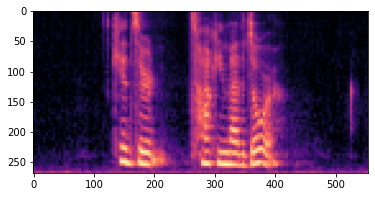

In [ ]:
pic = imageio.imread(find_dti('sad')[0], as_gray=False, pilmode="RGB")
plt.imshow(pic)

In [ ]:
np.max(pic)

254

In [ ]:
print('Type of the image : ' , type(pic))
print()
print('Shape of the image : {}'.format(pic.shape))
print('Image Hight {}'.format(pic.shape[0]))
print('Image Width {}'.format(pic.shape[1]))
print('Dimension of Image {}'.format(pic.ndim))

Type of the image :  <class 'imageio.core.util.Array'>

Shape of the image : (268, 554, 3)
Image Hight 268
Image Width 554
Dimension of Image 3


In [ ]:
pic[:,:,0]

Array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   2,   2,   3],
       [  0,   0,   0, ...,   2,   2,   3],
       ...,
       [ 27, 134, 134, ..., 173, 173, 160],
       [ 27, 134, 134, ..., 173, 173, 160],
       [ 27, 134, 134, ..., 173, 173, 160]], dtype=uint8)

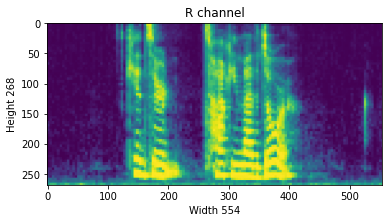

In [ ]:
plt.title('R channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 0])
plt.show()

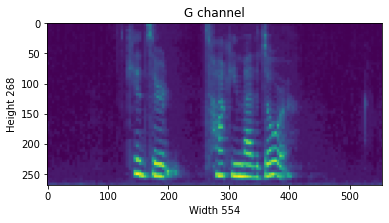

In [ ]:
plt.title('G channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 1])
plt.show()

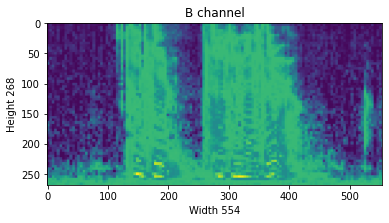

In [ ]:
plt.title('B channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 2])
plt.show()

*En general, el hecho de usar esta librería nos consumía muchísima RAM y nos hacía colapsar el google collab entonces preferimos optar por otra, que será la librería Pill.*

---
### Importar imágenes con MATPLOT

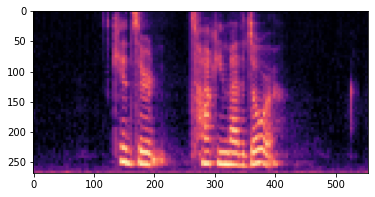

In [ ]:
pic = plt.imread(find_dti('sad')[0])
plt.imshow(pic)

In [ ]:
np.max(pic)

1.0

In [ ]:
print('Type of the image : ' , type(pic))
print()
print('Shape of the image : {}'.format(pic.shape))
print('Image Hight {}'.format(pic.shape[0]))
print('Image Width {}'.format(pic.shape[1]))
print('Dimension of Image {}'.format(pic.shape[2]))

Type of the image :  <class 'numpy.ndarray'>

Shape of the image : (268, 554, 4)
Image Hight 268
Image Width 554
Dimension of Image 4


In [ ]:
pic[:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.01176471],
       ...,
       [0.10588235, 0.5254902 , 0.5254902 , ..., 0.6784314 , 0.6784314 ,
        0.627451  ],
       [0.10588235, 0.5254902 , 0.5254902 , ..., 0.6784314 , 0.6784314 ,
        0.627451  ],
       [0.10588235, 0.5254902 , 0.5254902 , ..., 0.6784314 , 0.6784314 ,
        0.627451  ]], dtype=float32)

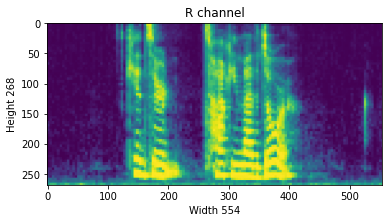

In [ ]:
plt.title('R channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 0])
plt.show()

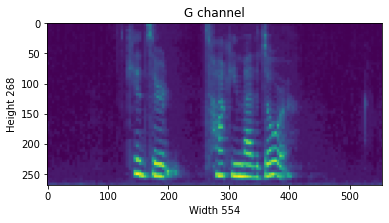

In [ ]:
plt.title('G channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 1])
plt.show()

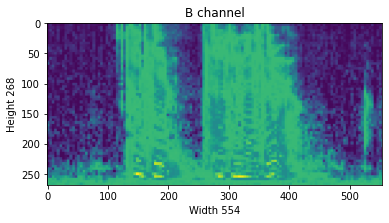

In [ ]:
plt.title('B channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 2])
plt.show()

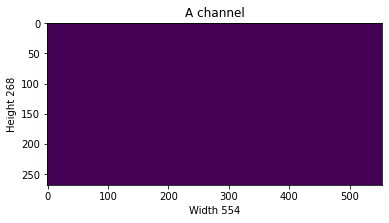

In [ ]:
plt.title('A channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 3])
plt.show()

La capa ALPHA no tiene información. Por tanto puede ser omitida.






## Preparación del MODELO

Algunos detalles fueron inspirados del tutorial  https://www.tensorflow.org/tutorials/images/classification. Primero que todo, cargamos las librerías correspondientes. Trabajaremos con la versión 2 de Tensor Flow.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from glob import glob #usa las reglas de shell de Unix para buscar nombres de archivos que coincidan con un patrón.
import librosa as lr #audios
import re #dividir cadena respecto a caracteres
import imageio #importar imágenes (PROBLEMAS RAM)
from PIL import Image #importar imágenes (resize)
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Versión de Tensorflow: " + tf.__version__)
from sklearn.metrics import confusion_matrix #matriz de confusión
import itertools #matriz de confusión

Versión de Tensorflow: 2.2.0


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

---
### Todos los datos en memoria (con muestreo)



> <h2> Datos </h2>

A continuación se efectúa un muestreo en nuestros datos para dividirlos en 3 conjuntos conservando la proporción de categorías para evitar sesgos adicionales en el modelo y sus resultados. El primero corresponde a los datos de entrenamiento del modelo y cubre la mayoría de los datos (80%). El segundo es datos de validación con los que el modelo evalúa su accuracy de validación, es decir, su capacidad para generalizar y clasificar datos con los que no ha entrenado. Finalmente dejamos un pequeño porcentaje de los datos (5%) para hacer test y predicciones, estos datos simulan el hecho de que aparezcan nuevos datos y ver cómo predice el modelo su comportamiento.

In [ ]:
POR_VAL = 15 #entero
POR_TEST = 5 #entero
seed = 50

path_train = np.array([])
path_val = np.array([])
path_test = np.array([])

for i in list(d['emotion'].keys()):

  np.random.seed(seed)

  path_e = np.array(find_di(emotion = i)) #direcciones de esa emoción
  l = len(path_e) #tamaño de muestras
  ind_t = np.array([j for j in range(l)]) #secuencia de números de tamaño l

  
  ind_val = np.random.choice(ind_t, l // 15, False) #muestreo
  ind_train = np.setdiff1d(ind_t, ind_val)

  ind_test = np.random.choice(ind_train, l // 5, False) #muestreo

  ind_train = np.setdiff1d(ind_train, ind_test)

  path_train = np.concatenate((path_train, path_e[ind_train]))
  path_val = np.concatenate((path_val, path_e[ind_val]))
  path_test = np.concatenate((path_test, path_e[ind_test]))

  seed += 1

np.random.seed(seed + 1)
path_train = np.random.choice(path_train, len(path_train), False)
path_val = np.random.choice(path_val, len(path_val), False)
path_test = np.random.choice(path_test, len(path_test), False)

In [ ]:
len(path_train) + len(path_val) + len(path_test)

1440

In [ ]:
CLASS_NAMES = np.array([f'0{i+1}' for i in range(8)]) #etiquetas
CLASS_NAMES

array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype='<U2')

Aquí se aplica una reducción de la dimensión de las imágenes para ahorrar tienpos de entrenamiento en los modelos y porque según varios experimentos que se hicieron de hecho aumentan algo el accuracy. Esta reducción se realiza por medio de la función Image.resize() la cuál tiene como método por defecto la interpolación bicúbica, que es más suave que otros métodos como "nearest neighbour" o "interpolación bilineal y que para cada pixel considera otros 16 pixeles para ajustar su valor.


In [ ]:
IMG_WIDTH = 277
IMG_HEIGHT = 134

def load_data(img_path=find_di()):
    
    x, y = [], []
    for i in range(len(img_path)):
        emotion = img_path[i][-18:-16] == CLASS_NAMES
        img = Image.open(img_path[i])
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.asarray(img) / 255.0
        x.append(img[:,:,:-1])
        y.append(emotion)

    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [ ]:
x_train, y_train = load_data(img_path = path_train)
x_val, y_val = load_data(img_path = path_val)
x_test, y_test = load_data(img_path = path_test)

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(32):
      ax = plt.subplot(8,4,n+1)
      plt.subplots_adjust(hspace = .5)
      plt.imshow(image_batch[n])
      plt.title(d['emotion'][CLASS_NAMES[label_batch[n]==1][0]].title())
      plt.axis('off')

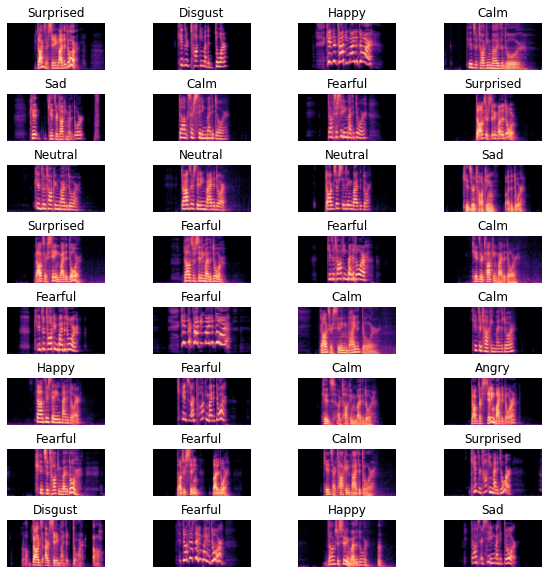

In [ ]:
r = np.random.randint(0, 1065, 32)
show_batch(x_train[r, :, :, :], y_train[r])

> <h2> Modelo inicial </h2>

Este es el primer modelo que abordamos desde Keras y consiste en una red neuronal artificial con una capa densa de 128 neuronas y función de activación Relu, así como una capa de salida, también fully connected con 8 neuronas (tantas como categorías de sentimientos).

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(8, activation = 'softmax')
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 111354)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               14253440  
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 1032      
Total params: 14,254,472
Trainable params: 14,254,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=32)

Epoch 1/50
34/34 [==============================] - 3s 87ms/step - loss: 11.3709 - accuracy: 0.2122 - val_loss: 3.1958 - val_accuracy: 0.3222
Epoch 2/50
34/34 [==============================] - 3s 85ms/step - loss: 2.7127 - accuracy: 0.3127 - val_loss: 2.2119 - val_accuracy: 0.3444
Epoch 3/50
34/34 [==============================] - 3s 85ms/step - loss: 1.7343 - accuracy: 0.4451 - val_loss: 1.9646 - val_accuracy: 0.3333
Epoch 4/50
34/34 [==============================] - 3s 84ms/step - loss: 1.4376 - accuracy: 0.4864 - val_loss: 1.6886 - val_accuracy: 0.3889
Epoch 5/50
34/34 [==============================] - 3s 83ms/step - loss: 1.3370 - accuracy: 0.5277 - val_loss: 2.0242 - val_accuracy: 0.3556
Epoch 6/50
34/34 [==============================] - 3s 84ms/step - loss: 1.0753 - accuracy: 0.6122 - val_loss: 1.5165 - val_accuracy: 0.4778
Epoch 7/50
34/34 [==============================] - 3s 86ms/step - loss: 1.0476 - accuracy: 0.6282 - val_loss: 2.0231 - val_accuracy: 0.5444
Epoch 8/50
3

#### Curvas (simple)

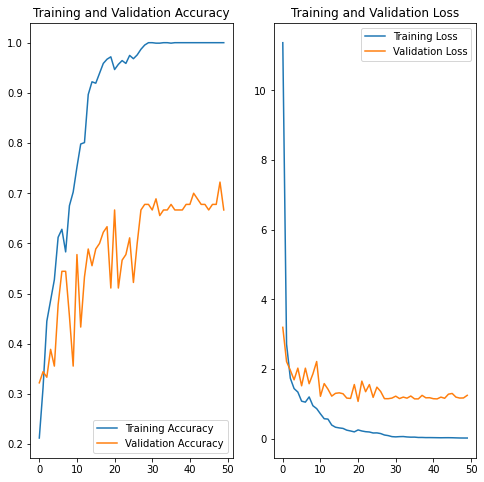

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
preds = model.predict(x_test)

In [ ]:
l_test = len(y_test)
y_t, y_p = [], []

for i in range(l_test):
  y_t.append(d['emotion'][CLASS_NAMES[y_test[i]][0]])
  y_p.append(d['emotion'][f'0{np.where(np.max(preds[i]) == preds[i])[0][0] + 1}'])

In [ ]:
cmat = confusion_matrix(y_t, y_p, labels = list(d['emotion'].values()))

#### Matriz de confusión (simple)

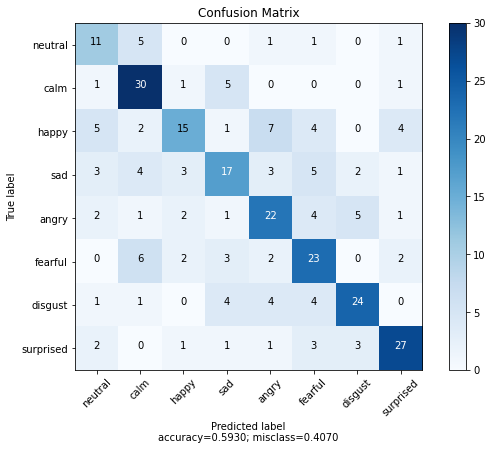

In [ ]:
plot_confusion_matrix(cm = cmat, 
normalize = False,
target_names = list(d['emotion'].values()),
title = "Confusion Matrix")

###Redes Neuronales Residuales (ResNet)



In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os

In [ ]:
# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
#epochs = 200
epochs = 20
data_augmentation = True
num_classes = 8
# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 2

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
model_type

'ResNet29v2'

In [ ]:
# input image dimensions.
input_shape = x_train.shape[1:]
input_shape

(134, 277, 3)

*Programa la actualización de la rata de aprendizaje*

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
      lr*=0.5e3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch >120:
      lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print('Learning rate: ', lr)
    return lr


Define la capa ResNet

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=8):
    """ResNet Version 1 Model builder 

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx 
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32)')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    modelj = Model(inputs=inputs, outputs=outputs)
    return modelj

In [ ]:
def resnet_v2(input_shape, depth, num_classes=8):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    modelj = Model(inputs=inputs, outputs=outputs)
    return modelj

Decidimos usar la versión uno y el modelo resnet 20 ya que no necesitamos tanta profundidad y debemos optimizar el tiempo de ejecución debido a las limitaciones computacionales. Por otro lado, se crearon callbacks para poder correr varias veces una serie de epochs y guardar los pesos del epoch que alcanzó el mejor accuracy de validación a cada vez.

In [ ]:
if version == 2:
    modelj = resnet_v2(input_shape=input_shape, depth=depth)
else:
    modelj = resnet_v1(input_shape=input_shape, depth=depth)

In [ ]:
modelj.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(81)),
              metrics=['accuracy'])
modelj.summary()
plot_model(modelj, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

In [ ]:
save_dir = '/content/drive/My Drive/project(dm)/modelos/'
model_name = 'Emociones_%s_model.{epoch:03d}.h5' % model_type
filepath = os.path.join(save_dir, model_name)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath

'/content/drive/My Drive/project(dm)/modelos/Emociones_ResNet29v2_model.{epoch:03d}.h5'

In [ ]:
# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
historyj = modelj.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32, callbacks=callbacks)

Learning rate:  0.001
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.5092 - accuracy: 0.2432 
Epoch 00001: val_accuracy improved from -inf to 0.21111, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.001.h5
34/34 [==============================] - 461s 14s/step - loss: 2.5092 - accuracy: 0.2432 - val_loss: 2.2278 - val_accuracy: 0.2111 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.7144 - accuracy: 0.4338 
Epoch 00002: val_accuracy improved from 0.21111 to 0.24444, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.002.h5
34/34 [==============================] - 460s 14s/step - loss: 1.7144 - accuracy: 0.4338 - val_loss: 2.5543 - val_accuracy: 0.2444 - lr: 0.0010
Learning rate:  0.001
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.5427 
Epoch 00003: val_accuracy did not improve from 0.24444
3

In [ ]:
if version == 2:
    modelj2 = resnet_v2(input_shape=input_shape, depth=depth)
else:
    modelj2 = resnet_v1(input_shape=input_shape, depth=depth)


In [ ]:
modelj2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
modelj2.summary()
plot_model(modelj2, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

In [ ]:
modelj2.load_weights('/content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.008.h5')

In [ ]:
historyj2=modelj2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32, callbacks=callbacks)

Learning rate:  0.001
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.8357 
Epoch 00001: val_accuracy improved from -inf to 0.41111, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.001.h5
34/34 [==============================] - 448s 13s/step - loss: 0.6889 - accuracy: 0.8357 - val_loss: 6.7304 - val_accuracy: 0.4111 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.9239 
Epoch 00002: val_accuracy improved from 0.41111 to 0.54444, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.002.h5
34/34 [==============================] - 444s 13s/step - loss: 0.3921 - accuracy: 0.9239 - val_loss: 1.9322 - val_accuracy: 0.5444 - lr: 0.0010
Learning rate:  0.001
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.9549 
Epoch 00003: val_accuracy did not improve from 0.54444
3

In [ ]:
if version == 2:
    modelj3 = resnet_v2(input_shape=input_shape, depth=depth)
else:
    modelj3 = resnet_v1(input_shape=input_shape, depth=depth)

In [ ]:
modelj3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(81)),
              metrics=['accuracy'])
modelj3.summary()
plot_model(modelj3, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Por ejemplo aquí se cargarán los pesos del mejor modelo obtenido el cual alcanzó un accuracy de validación de 85%.

In [ ]:
modelj3.load_weights('/content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.039.h5')

In [ ]:
historyj3=modelj3.fit(x_train, y_train, epochs=40, validation_data=(x_val, y_val), batch_size=32, callbacks=callbacks)

Learning rate:  0.001
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.9455 
Epoch 00001: val_accuracy improved from -inf to 0.65556, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.001.h5
34/34 [==============================] - 453s 13s/step - loss: 0.2879 - accuracy: 0.9455 - val_loss: 1.8165 - val_accuracy: 0.6556 - lr: 0.0010
Learning rate:  0.001
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9643 
Epoch 00002: val_accuracy did not improve from 0.65556
34/34 [==============================] - 453s 13s/step - loss: 0.2321 - accuracy: 0.9643 - val_loss: 2.7211 - val_accuracy: 0.5111 - lr: 0.0010
Learning rate:  0.001
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9718 
Epoch 00003: val_accuracy improved from 0.65556 to 0.67778, saving model to /content/drive/My Drive/project(dm)/modelos/Emociones_ResNet20v1_model.003.h5
3

Finalmente, después de 40 epochs más y una pequeña reducción en la taza de aprendizaje el modelo sube a 87.78% de accuracy de validación. Esto tardó en total aproximadamente 120 epochs.

#### Curvas

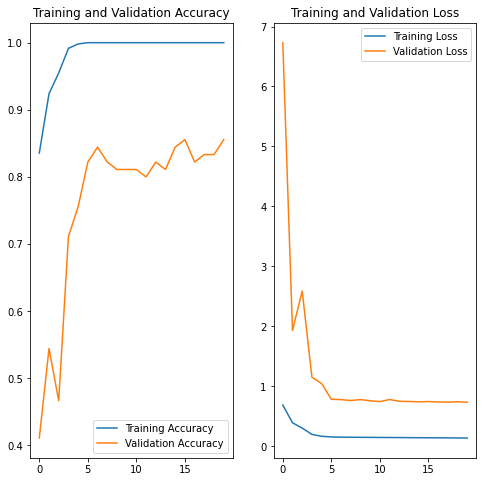

In [ ]:
acc = historyj2.history['accuracy']
val_acc = historyj2.history['val_accuracy']

loss=historyj2.history['loss']
val_loss=historyj2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predsj3 = modelj3.predict(x_test)

In [ ]:
l_test = len(y_test)
y_t, y_p = [], []

for i in range(l_test):
  y_t.append(d['emotion'][CLASS_NAMES[y_test[i]][0]])
  y_p.append(d['emotion'][f'0{np.where(np.max(predsj3[i]) == predsj3[i])[0][0] + 1}'])

In [ ]:
cmatj = confusion_matrix(y_t, y_p, labels = list(d['emotion'].values()))

#### Matriz de confusión

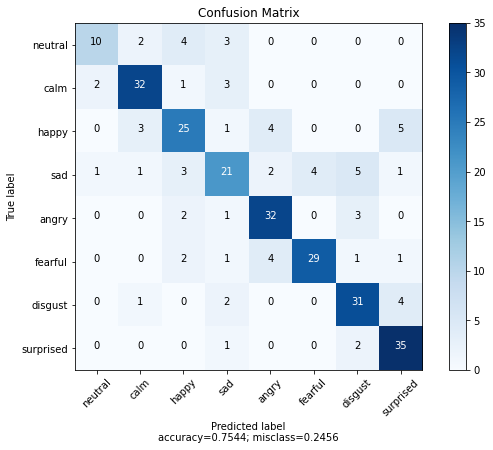

In [ ]:
plot_confusion_matrix(cm = cmatj, 
normalize = False,
target_names = list(d['emotion'].values()),
title = "Confusion Matrix")


In [ ]:
cmatj_exp = np.array(
  [ 
    [10, 2, 4, 3, 0, 0, 0, 0], 
    [2, 32, 1, 3, 0, 0, 0, 0], 
    [0, 3, 25, 1, 4, 0, 0, 5], 
    [1, 1, 3, 21, 2, 4, 5, 1], 
    [0, 0, 2, 1, 32, 0, 3, 0], 
    [0, 0, 2, 1, 4, 29, 1, 1], 
    [0, 1, 0, 2, 0, 0, 31, 4], 
    [0, 0, 0, 1, 0, 0, 2, 35]
  ]
)

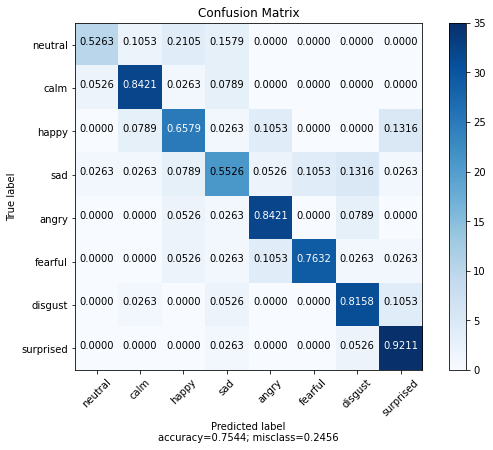

In [ ]:
plot_confusion_matrix(cm = cmatj_exp, 
normalize = True,
target_names = list(d['emotion'].values()),
title = "Confusion Matrix")

---
### Datos con iteradores (con muestreo, reducción de dimensión y Dropout) </h1>

> <h2> Datos </h2>

Muestreo:

In [ ]:
POR_VAL = 15 #entero
POR_TEST = 5 #entero
seed = 50

path_train = np.array([])
path_val = np.array([])
path_test = np.array([])

for i in list(d['emotion'].keys()):

  np.random.seed(seed)

  path_e = np.array(find_di(emotion = i)) #direcciones de esa emoción
  l = len(path_e) #tamaño de muestras
  ind_t = np.array([j for j in range(l)]) #secuencia de números de tamaño l

  
  ind_val = np.random.choice(ind_t, l // 15, False) #muestreo
  ind_train = np.setdiff1d(ind_t, ind_val)

  ind_test = np.random.choice(ind_train, l // 5, False) #muestreo

  ind_train = np.setdiff1d(ind_train, ind_test)

  path_train = np.concatenate((path_train, path_e[ind_train]))
  path_val = np.concatenate((path_val, path_e[ind_val]))
  path_test = np.concatenate((path_test, path_e[ind_test]))

  seed += 1

np.random.seed(seed + 1)
path_train = np.random.choice(path_train, len(path_train), False)
path_val = np.random.choice(path_val, len(path_val), False)
path_test = np.random.choice(path_test, len(path_test), False)

In [ ]:
len(path_train) + len(path_val) + len(path_test)

1440

Se procede a cargar los datos inspirados en el tutorial: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
list_tr = tf.data.Dataset.list_files(path_train)
list_val = tf.data.Dataset.list_files(path_val)

In [ ]:
list_tr

<ShuffleDataset shapes: (), types: tf.string>

In [ ]:
for f in list_tr.take(5):
  print(f.numpy())

b'/content/drive/My Drive/project(dm)/speech_img/03-01-05-01-02-01-09.png'
b'/content/drive/My Drive/project(dm)/speech_img/03-01-02-01-02-01-15.png'
b'/content/drive/My Drive/project(dm)/speech_img/03-01-06-02-01-02-21.png'
b'/content/drive/My Drive/project(dm)/speech_img/03-01-08-01-02-02-03.png'
b'/content/drive/My Drive/project(dm)/speech_img/03-01-03-02-02-01-06.png'


In [ ]:
CLASS_NAMES = np.array([f'0{i+1}' for i in range(8)]) #etiquetas
CLASS_NAMES

array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype='<U2')

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '-')
  # The second to last is the class-directory
  return parts[2] == CLASS_NAMES

In [ ]:
IMG_WIDTH = 277
IMG_HEIGHT = 134

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
labeled_tr = list_tr.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_val = list_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
labeled_tr

<ParallelMapDataset shapes: ((134, 277, 3), (8,)), types: (tf.float32, tf.bool)>

In [ ]:
for image, label in labeled_tr.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (134, 277, 3)
Label:  [False False False  True False False False False]
Image shape:  (134, 277, 3)
Label:  [False False False False False False  True False]
Image shape:  (134, 277, 3)
Label:  [False False False False False False False  True]
Image shape:  (134, 277, 3)
Label:  [False False False  True False False False False]
Image shape:  (134, 277, 3)
Label:  [False False False False  True False False False]


In [ ]:
BATCH_SIZE = 32

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1440):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
ltrai = len(path_train)
lval = len(path_val)

In [ ]:
train_ds = prepare_for_training(labeled_tr, shuffle_buffer_size = ltrai)
val_ds = prepare_for_training(labeled_val, shuffle_buffer_size = lval)

In [ ]:
val_ds

<PrefetchDataset shapes: ((None, 134, 277, 3), (None, 8)), types: (tf.float32, tf.bool)>

In [ ]:
image_batch, label_batch = next(iter(train_ds))

In [ ]:
image_batch[0][:,:,0]

<tf.Tensor: shape=(134, 277), dtype=float32, numpy=
array([[0.01176471, 0.01960784, 0.00980392, ..., 0.        , 0.        ,
        0.        ],
       [0.02352941, 0.03921569, 0.01960784, ..., 0.        , 0.        ,
        0.        ],
       [0.0254902 , 0.04313726, 0.01764706, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16078433, 0.27058825, 0.02352941, ..., 0.07450981, 0.07450981,
        0.12941177],
       [0.19803923, 0.32941177, 0.15294118, ..., 0.2509804 , 0.2509804 ,
        0.23137257],
       [0.19803923, 0.32941177, 0.15294118, ..., 0.2509804 , 0.2509804 ,
        0.23137257]], dtype=float32)>

In [ ]:
np.max(image_batch[0])

0.9960785

Para tener una representación visual de que forma tienen los datos se crea la función que muestra cómo luciría uno de los lotes de entrada de nuestros modelos.

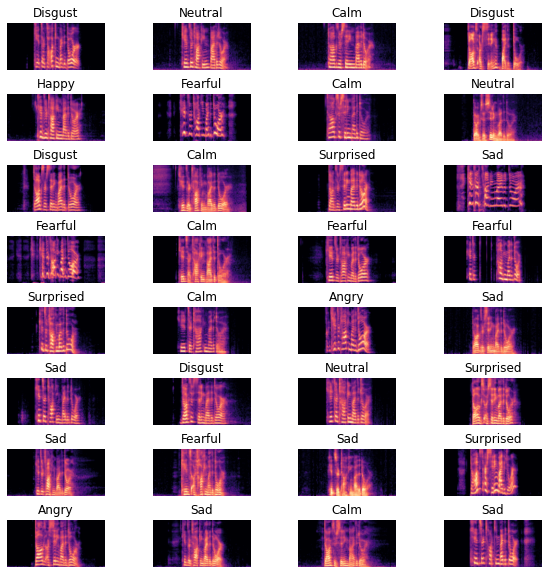

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
IMG_WIDTH = 277
IMG_HEIGHT = 134

def load_data(img_path=find_di()):
    
    x, y = [], []
    for i in range(len(img_path)):
        emotion = img_path[i][-18:-16] == CLASS_NAMES
        img = Image.open(img_path[i])
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.asarray(img) / 255.0
        x.append(img[:,:,:-1])
        y.append(emotion)

    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [ ]:
x_test, y_test = load_data(img_path = path_test)

> <h2> Modelo inicial </h2>

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(8, activation = 'softmax')
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 111354)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               14253440  
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 1032      
Total params: 14,254,472
Trainable params: 14,254,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    steps_per_epoch = ltrai // BATCH_SIZE,
    epochs = 50,
    validation_steps = lval // BATCH_SIZE
)

Epoch 1/50
33/33 [==============================] - 3s 88ms/step - loss: 15.9632 - accuracy: 0.2197 - val_loss: 7.2502 - val_accuracy: 0.3438
Epoch 2/50
33/33 [==============================] - 3s 85ms/step - loss: 3.3409 - accuracy: 0.3759 - val_loss: 2.2665 - val_accuracy: 0.4531
Epoch 3/50
33/33 [==============================] - 3s 85ms/step - loss: 2.2421 - accuracy: 0.4517 - val_loss: 1.8969 - val_accuracy: 0.5469
Epoch 4/50
33/33 [==============================] - 3s 87ms/step - loss: 1.9858 - accuracy: 0.5085 - val_loss: 2.0593 - val_accuracy: 0.5000
Epoch 5/50
33/33 [==============================] - 3s 88ms/step - loss: 1.3497 - accuracy: 0.5881 - val_loss: 2.2022 - val_accuracy: 0.4219
Epoch 6/50
33/33 [==============================] - 3s 87ms/step - loss: 1.3304 - accuracy: 0.6241 - val_loss: 2.4232 - val_accuracy: 0.3906
Epoch 7/50
33/33 [==============================] - 3s 85ms/step - loss: 1.0321 - accuracy: 0.6600 - val_loss: 1.7643 - val_accuracy: 0.5312
Epoch 8/50
3

#### Curvas (simple)

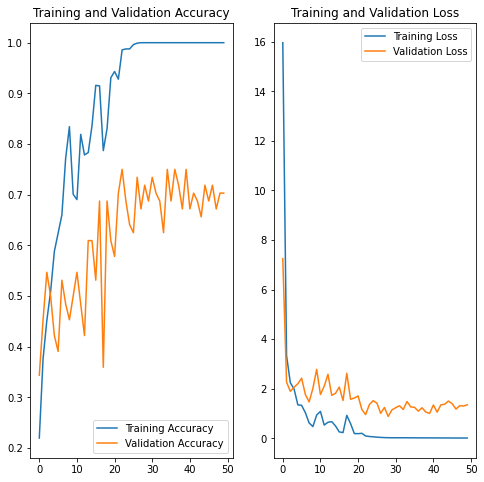

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
preds = model.predict(x_test)

In [ ]:
l_test = len(y_test)
y_t, y_p = [], []

for i in range(l_test):
  y_t.append(d['emotion'][CLASS_NAMES[y_test[i]][0]])
  y_p.append(d['emotion'][f'0{np.where(np.max(preds[i]) == preds[i])[0][0] + 1}'])

In [ ]:
cmat = confusion_matrix(y_t, y_p, labels = list(d['emotion'].values()))

#### Matriz de confusión (simple)

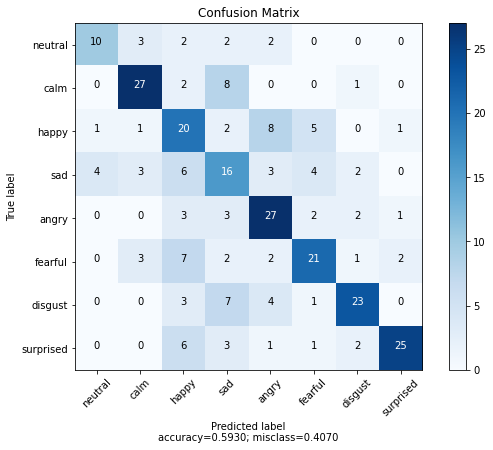

In [ ]:
plot_confusion_matrix(cm = cmat, 
normalize = False,
target_names = list(d['emotion'].values()),
title = "Confusion Matrix")



> <h2> Convoluciones (Con Dropout) </h2>



In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
for i in [16, 32, 64]:
  model2.add(tf.keras.layers.Conv2D(i, 3, padding='same', activation='relu'))
  model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(512, activation='relu')) #600
model2.add(tf.keras.layers.Dropout(0.1)) #0.1
model2.add(tf.keras.layers.Dense(8, activation='softmax'))

In [ ]:
model2.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 134, 277, 16)      448       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 67, 138, 16)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 67, 138, 32)       4640      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 33, 69, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 33, 69, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 34, 64)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 34816)           

In [ ]:
history2 = model2.fit(
    train_ds,
    validation_data = val_ds,
    steps_per_epoch = ltrai // BATCH_SIZE,
    epochs = 15,
    validation_steps = lval // BATCH_SIZE
)

Epoch 1/15
33/33 [==============================] - 41s 1s/step - loss: 2.0657 - accuracy: 0.2377 - val_loss: 1.8769 - val_accuracy: 0.2969
Epoch 2/15
33/33 [==============================] - 37s 1s/step - loss: 1.5916 - accuracy: 0.4081 - val_loss: 1.3226 - val_accuracy: 0.5625
Epoch 3/15
33/33 [==============================] - 37s 1s/step - loss: 1.2015 - accuracy: 0.5663 - val_loss: 1.1093 - val_accuracy: 0.5938
Epoch 4/15
33/33 [==============================] - 38s 1s/step - loss: 0.8858 - accuracy: 0.6600 - val_loss: 1.1624 - val_accuracy: 0.5625
Epoch 5/15
33/33 [==============================] - 37s 1s/step - loss: 0.6178 - accuracy: 0.7869 - val_loss: 1.0261 - val_accuracy: 0.6094
Epoch 6/15
33/33 [==============================] - 37s 1s/step - loss: 0.3905 - accuracy: 0.8665 - val_loss: 1.0539 - val_accuracy: 0.6719
Epoch 7/15
33/33 [==============================] - 37s 1s/step - loss: 0.2062 - accuracy: 0.9394 - val_loss: 0.9704 - val_accuracy: 0.6562
Epoch 8/15
33/33 [==

#### Curvas (Conv)

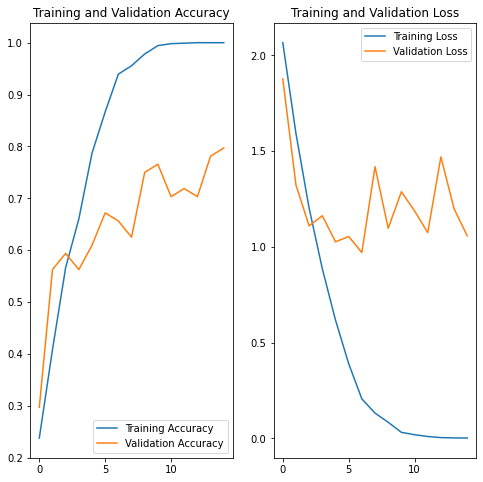

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
x_test.shape

(285, 134, 277, 3)

In [ ]:
preds2 = model2.predict(x_test)

In [ ]:
l_test = len(y_test)
y_t, y_p = [], []

for i in range(l_test):
  y_t.append(d['emotion'][CLASS_NAMES[y_test[i]][0]])
  y_p.append(d['emotion'][f'0{np.where(np.max(preds2[i]) == preds2[i])[0][0] + 1}'])

In [ ]:
cmat2 = confusion_matrix(y_t, y_p, labels = list(d['emotion'].values()))

#### Matriz de confusión (conv)

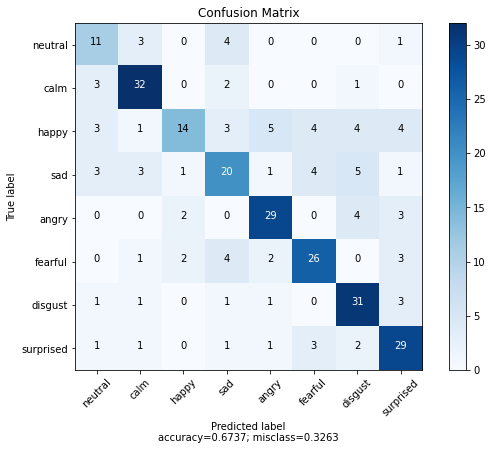

In [ ]:
plot_confusion_matrix(cm = cmat2, 
normalize = False,
target_names = list(d['emotion'].values()),
title = "Confusion Matrix")



## Alternativas a KERAS/TF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
img_path = find_di()
len(img_path)

1440

In [ ]:
pic = imageio.imread(find_dti('sad')[0], as_gray=False, pilmode="RGB")
x, y, z = pic.shape
sz = x*y*z

In [ ]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for i in range(len(img_path)):
        emotion=img_path[i][-18:-16]
        feature=imageio.imread(img_path[i], as_gray=False, pilmode="RGB")
        feature.resize(sz)
        feature2=feature.T
        x.append(feature2)
        y.append(emotion)
        
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

Aquí dividimos nuestros datos en entrenamiento y test:

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.1)


In [ ]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1296, 144)


In [ ]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 498525


---
### MLPClassifier (SKLEARN)

Ahora, inicializamos el  MLPClassifier. Es un clasificador multicapa perceptron; optimiza la función de pérdida usando LBFGS o el descenso del gradiente estocástico. Diferente a SVM o Naive Bayes, el MLPClassifier tiene una red neuronal interna para el propósito de clasificación. Este modelo es una red neuronal prealimentada (feedforward ANN).




In [ ]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)



Ahora entrenamos el modelo (tardó aproximadamente una hora)



In [ ]:
#DataFlair - Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
y_pred=model.predict(x_test)

Vamos a calcular la precisión de nuestro modelo, usaremos la función accuracy_score() que importamos previamente de sklearn. Finalmente se aproximará el resultado a dos cifras decimales y se imprimirá.

In [ ]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 61.11%


Aquí encontramos detalles sobre esta función: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 



### CNN_learner (FAST.AI)

Inspirado en: https://towardsdatascience.com/sound-classification-using-images-68d4770df426
y 
https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89 
Por ahora no pasa del 50% de accuracy

In [ ]:
from fastai.train import ShowGraph
from fastai.vision import (
    accuracy,
    create_cnn,
    models,
)
from fastai.vision import *
from fastai.vision.data import (
    ImageDataBunch   
)
from fastai.vision import ClassificationInterpretation
from fastai.vision.transform import get_transforms
import matplotlib.pyplot as plt
import torch
import torchvision.models as torch_models

In [ ]:
pattern = r'.*(.{2}).{16}$' #Regular Expression RegEx que permite extraer los dígitos correspoindientes a la emoción
data = (ImageList.from_folder(data_i)
          .split_by_rand_pct(0.2) #Selecciona un trainung set de 20%
          .label_from_re(pattern)
          .databunch())

In [ ]:
data

ImageDataBunch;

Train: LabelList (1152 items)
x: ImageList
Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554)
y: CategoryList
04,04,04,04,04
Path: /content/drive/My Drive/project(dm)/speech_img;

Valid: LabelList (288 items)
x: ImageList
Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554),Image (3, 268, 554)
y: CategoryList
07,04,01,04,03
Path: /content/drive/My Drive/project(dm)/speech_img;

Test: None

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,3.095901,2.241930,0.232639,10:08
1,2.419896,1.962120,0.378472,10:04
2,1.866404,1.822942,0.416667,10:07
3,1.442971,1.923595,0.413194,10:08
4,1.110860,1.967553,0.427083,10:09
5,0.849892,1.941261,0.423611,10:18
6,0.660423,1.976188,0.413194,10:12
7,0.530242,1.973817,0.430556,10:08
8,0.437519,1.961224,0.437500,10:08
9,0.363710,1.971570,0.423611,10:11


In [ ]:
learn2=cnn_learner(data, models.resnet34, metrics=accuracy)
learn2.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.171676,2.357531,0.194444,18:34
1,2.426620,2.138975,0.354167,18:50
2,1.862987,1.927645,0.423611,18:42
3,1.410697,1.931077,0.472222,19:15
4,1.073146,1.897296,0.454861,19:16
5,0.817451,1.921184,0.475694,19:32
6,0.638551,1.937123,0.486111,22:26
7,0.500671,1.954629,0.468750,19:48
8,0.394835,1.963819,0.482639,18:55
9,0.325421,1.968193,0.479167,18:47
